In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the preprocessed data
df = pd.read_csv('~/Desktop/bert_imdb_data/df_grouped_bert.csv')
df_test_hidden = pd.read_csv('~/Desktop/bert_imdb_data/test_bert_sentiment.csv')
df_validation_hidden = pd.read_csv('~/Desktop/bert_imdb_data/validation_bert_sentiment.csv')

In [8]:
df

,tconst,numVotes,like_count,tomatometer_status,tomatometer_rating,audience_status,audience_rating,bert_sentiment,movie_title,year,genre,content_rating,production_company,label,reviews,review_lemmatized
0,tt0016029,1646.0,0.0,1.0,78.0,1.0,80.0,4.00,the little colonel,1935,Unknown,Unknown,Unknown,True,"THE LITTLE COLONEL (Fox, 1935), directed by Da...",littl colonel fox 1935 direct david butler sta...
1,tt0017961,1080.0,0.0,1.0,78.0,1.0,80.0,3.00,happiness,1935,Unknown,Unknown,Unknown,True,"I really love silent cinema of all types, and ...",realli love silent cinema type favorit film si...
2,tt0020298,3226.0,0.0,1.0,78.0,1.0,80.0,2.25,queen kelly,1932,Unknown,Unknown,Unknown,True,I'd imagine that most people who would come to...,d imagin peopl come page read review erich von...
3,tt0020768,3199.0,0.0,1.0,78.0,1.0,80.0,3.50,city girl,1930,Unknown,Unknown,Unknown,True,Silent film may be the only unique art form ev...,silent film may uniqu art form ever flourish b...
4,tt0021309,0.0,0.0,1.0,78.0,1.0,80.0,3.25,the story of the fox,1937,Unknown,Unknown,Unknown,True,One of the first animated feature films of the...,one first anim featur film world tale fox stil...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,tt9850344,1325.0,0.0,1.0,78.0,1.0,80.0,4.00,night shift,2020,Unknown,Unknown,Unknown,False,It would have been much better to have a longe...,much better longer first part unlik second par...
7808,tt9850386,4144.0,0.0,1.0,78.0,1.0,80.0,3.75,the bee gees: how can you mend a broken heart,2020,Unknown,Unknown,Unknown,True,"""The Bee Gees: How Can You Mend A Broken Heart...",bee gee mend broken heart 2020 releas 111 min ...
7809,tt9900782,0.0,0.0,1.0,78.0,1.0,80.0,4.00,kaithi,2019,Unknown,Unknown,Unknown,True,"A drug burst, an injured cop and a Convicted C...",drug burst injur cop convict crimin want meet ...
7810,tt9904802,0.0,0.0,1.0,78.0,1.0,80.0,1.75,enemy lines,2020,Unknown,Unknown,Unknown,False,"Is my first impression, its the lack of determ...",first impress lack determin determin whole plo...


In [10]:
df = df.drop(columns=[
    "like_count", 
    "tomatometer_status", 
    "tomatometer_rating", 
    "audience_status", 
    "audience_rating", 
    "content_rating", 
    "production_company",
    "reviews",
    "review_lemmatized"
    ])
df

,tconst,numVotes,bert_sentiment,movie_title,year,genre,label
0,tt0016029,1646.0,4.00,the little colonel,1935,Unknown,True
1,tt0017961,1080.0,3.00,happiness,1935,Unknown,True
2,tt0020298,3226.0,2.25,queen kelly,1932,Unknown,True
3,tt0020768,3199.0,3.50,city girl,1930,Unknown,True
4,tt0021309,0.0,3.25,the story of the fox,1937,Unknown,True
...,...,...,...,...,...,...,...
7807,tt9850344,1325.0,4.00,night shift,2020,Unknown,False
7808,tt9850386,4144.0,3.75,the bee gees: how can you mend a broken heart,2020,Unknown,True
7809,tt9900782,0.0,4.00,kaithi,2019,Unknown,True
7810,tt9904802,0.0,1.75,enemy lines,2020,Unknown,False


In [16]:
df_genre = pd.read_csv("~/Desktop/genre2movies.csv")
df_genre

,genre,movie
0,buddy,Toy Story (1995)
1,buddy,Grumpier Old Men (1995)
2,buddy,Bio-Dome (1996)
3,buddy,Friday (1995)
4,buddy,Big Bully (1996)
...,...,...
83664,collage,21-87 (1963)
83665,bdsm,Fifty Shades of Grey (2015)
83666,persian,Falcon Rising (2014)
83667,terror,Nazareno Cruz and the Wolf (1975)


In [56]:
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
genres = pd.read_csv("hf://datasets/jquigl/imdb-genres/" + splits["train"])
genres.head()

,movie title - year,genre,expanded-genres,rating,description
0,Flaming Ears - 1992,Fantasy,"Fantasy, Sci-Fi",6.0,Flaming Ears is a pop sci-fi lesbian fantasy f...
1,Jeg elsker dig - 1957,Romance,"Comedy, Drama, Romance",5.8,Six people - three couples - meet at random at...
2,Povjerenje - 2021,Thriller,Thriller,NaN,"In a small unnamed town, in year 2025, Krsto w..."
3,Gulliver Returns - 2021,Fantasy,"Animation, Adventure, Family",4.4,The legendary Gulliver returns to the Kingdom ...
4,Prithvi Vallabh - 1924,Biography,"Biography, Drama, Romance",NaN,"Seminal silent historical film, the story feat..."


In [46]:
genres.columns

Index(['movie title - year', 'genre', 'expanded-genres', 'rating',
       'description'],
      dtype='object')

In [63]:
# genres = genres.drop(columns=['expanded-genres', 'rating', 'description'])

# genres[['movie_title', 'year']] = genres['movie title - year'].str.extract(r'^(.+)\s*-\s*(\d{4})$')
genres['title_only'] = genres['movie title - year'].str.split(' - ', n=1).str[0]
#genres = genres.dropna(subset=['year'])  # Remove rows where extraction failed
#genres['year'] = genres['year'].astype(int)
genres["title_only"] = genres["title_only"].str.lower()

genres

,movie title - year,genre,movie_title,year,title_only
0,Flaming Ears - 1992,Fantasy,flaming ears,1992,flaming ears
1,Jeg elsker dig - 1957,Romance,jeg elsker dig,1957,jeg elsker dig
2,Povjerenje - 2021,Thriller,povjerenje,2021,povjerenje
3,Gulliver Returns - 2021,Fantasy,gulliver returns,2021,gulliver returns
4,Prithvi Vallabh - 1924,Biography,prithvi vallabh,1924,prithvi vallabh
...,...,...,...,...,...
238251,Kaalapani - 1996,History,kaalapani,1996,kaalapani
238252,The Set-Up - 2014,Action,the set-up,2014,the set-up
238253,Der Bucklige von Soho - 1966,Horror,der bucklige von soho,1966,der bucklige von soho
238254,The Shadow Thing - nan,Horror,NaN,NaN,the shadow thing


In [64]:
genres = genres.drop(columns=["movie title - year", "movie_title"])

In [66]:
genres["movie_title"] = genres["title_only"]
genres = genres.drop(columns="title_only")
genres

,genre,year,movie_title
0,Fantasy,1992,flaming ears
1,Romance,1957,jeg elsker dig
2,Thriller,2021,povjerenje
3,Fantasy,2021,gulliver returns
4,Biography,1924,prithvi vallabh
...,...,...,...
238251,History,1996,kaalapani
238252,Action,2014,the set-up
238253,Horror,1966,der bucklige von soho
238254,Horror,NaN,the shadow thing


In [67]:
merged_df = pd.merge(genres, df, on=['movie_title'], how='right')

In [68]:
merged_df["genre_x"].value_counts()

genre_x
Thriller     3088
Romance      2005
Action       1894
Horror       1860
Crime        1627
Mystery      1033
Adventure    1009
Scifi         877
Fantasy       818
Family        642
War           386
Biography     355
History       280
Animation     255
Sports        184
Film-noir     100
Name: count, dtype: int64

In [69]:
merged_df["genre"] = merged_df["genre_x"]
merged_df = merged_df.drop(columns=["genre_x", "genre_y"])
merged_df

,year_x,movie_title,tconst,numVotes,bert_sentiment,year_y,label,genre
0,1935,the little colonel,tt0016029,1646.0,4.00,1935,True,Romance
1,1935,the little colonel,tt0016029,1646.0,4.00,1935,True,Family
2,NaN,happiness,tt0017961,1080.0,3.00,1935,True,Action
3,NaN,queen kelly,tt0020298,3226.0,2.25,1932,True,NaN
4,NaN,city girl,tt0020768,3199.0,3.50,1930,True,NaN
...,...,...,...,...,...,...,...,...
18617,2019,kaithi,tt9900782,0.0,4.00,2019,True,Crime
18618,2019,kaithi,tt9900782,0.0,4.00,2019,True,Adventure
18619,2019,kaithi,tt9900782,0.0,4.00,2019,True,Action
18620,2020,enemy lines,tt9904802,0.0,1.75,2020,False,War


In [70]:
merged_df["year"] = merged_df["year_y"]
merged_df = merged_df.drop(columns=["year_x", "year_y"])
merged_df

,movie_title,tconst,numVotes,bert_sentiment,label,genre,year
0,the little colonel,tt0016029,1646.0,4.00,True,Romance,1935
1,the little colonel,tt0016029,1646.0,4.00,True,Family,1935
2,happiness,tt0017961,1080.0,3.00,True,Action,1935
3,queen kelly,tt0020298,3226.0,2.25,True,NaN,1932
4,city girl,tt0020768,3199.0,3.50,True,NaN,1930
...,...,...,...,...,...,...,...
18617,kaithi,tt9900782,0.0,4.00,True,Crime,2019
18618,kaithi,tt9900782,0.0,4.00,True,Adventure,2019
18619,kaithi,tt9900782,0.0,4.00,True,Action,2019
18620,enemy lines,tt9904802,0.0,1.75,False,War,2020


In [71]:
# Frequency encoding
genre_freq = merged_df['genre'].value_counts()  # Get frequency of each genre
merged_df['genre_encoded'] = merged_df['genre'].map(genre_freq).fillna(0)

In [72]:
merged_df

,movie_title,tconst,numVotes,bert_sentiment,label,genre,year,genre_encoded
0,the little colonel,tt0016029,1646.0,4.00,True,Romance,1935,2005.0
1,the little colonel,tt0016029,1646.0,4.00,True,Family,1935,642.0
2,happiness,tt0017961,1080.0,3.00,True,Action,1935,1894.0
3,queen kelly,tt0020298,3226.0,2.25,True,NaN,1932,0.0
4,city girl,tt0020768,3199.0,3.50,True,NaN,1930,0.0
...,...,...,...,...,...,...,...,...
18617,kaithi,tt9900782,0.0,4.00,True,Crime,2019,1627.0
18618,kaithi,tt9900782,0.0,4.00,True,Adventure,2019,1009.0
18619,kaithi,tt9900782,0.0,4.00,True,Action,2019,1894.0
18620,enemy lines,tt9904802,0.0,1.75,False,War,2020,386.0


In [74]:
writing = pd.read_json("~/Desktop/writing.json")
directors = pd.read_json("~/Desktop/directing.json")

In [75]:
print(writing.head())
print(directors.head())

       movie     writer
0  tt0003740  nm0195339
1  tt0003740  nm0515385
2  tt0003740  nm0665163
3  tt0003740  nm0758215
4  tt0008663  nm0406585
       movie   director
0  tt0003740  nm0665163
1  tt0008663  nm0803705
2  tt0009369  nm0428059
3  tt0009369  nm0949648
4  tt0010307  nm0304098


In [79]:
df_writers_grouped = (
    writing
    .groupby('movie')['writer']
    .apply(list)
    .reset_index(name='writers')
)

df_directors_grouped = (
    directors
    .groupby('movie')['director']
    .apply(list)
    .reset_index(name='directors')
)

print(df_writers_grouped)
df_directors_grouped


          movie                                       writers
0     tt0003740  [nm0195339, nm0515385, nm0665163, nm0758215]
1     tt0008663             [nm0406585, nm0596410, nm0803705]
2     tt0009369                        [nm0215874, nm0370271]
3     tt0010307                                   [nm0304098]
4     tt0010600  [nm0006782, nm0473134, nm0523932, nm0932559]
...         ...                                           ...
9995  tt9850344             [nm3124777, nm1987983, nm0284774]
9996  tt9850386                                   [nm0598531]
9997  tt9900782                        [nm7992231, nm7807469]
9998  tt9904802                        [nm0942647, nm3853396]
9999  tt9911196             [nm2063122, nm0277932, nm3547655]

[10000 rows x 2 columns]


,movie,directors
0,tt0003740,[nm0665163]
1,tt0008663,[nm0803705]
2,tt0009369,"[nm0428059, nm0949648]"
3,tt0010307,[nm0304098]
4,tt0010600,[nm0523932]
...,...,...
9995,tt9850344,[nm0284774]
9996,tt9850386,[nm0550881]
9997,tt9900782,[nm7992231]
9998,tt9904802,[nm0052054]


In [80]:
df_writers_directors = pd.merge(df_writers_grouped, 
                                df_directors_grouped, 
                                on='movie', 
                                how='outer')

df_writers_directors

,movie,writers,directors
0,tt0003740,"[nm0195339, nm0515385, nm0665163, nm0758215]",[nm0665163]
1,tt0008663,"[nm0406585, nm0596410, nm0803705]",[nm0803705]
2,tt0009369,"[nm0215874, nm0370271]","[nm0428059, nm0949648]"
3,tt0010307,[nm0304098],[nm0304098]
4,tt0010600,"[nm0006782, nm0473134, nm0523932, nm0932559]",[nm0523932]
...,...,...,...
9995,tt9850344,"[nm3124777, nm1987983, nm0284774]",[nm0284774]
9996,tt9850386,[nm0598531],[nm0550881]
9997,tt9900782,"[nm7992231, nm7807469]",[nm7992231]
9998,tt9904802,"[nm0942647, nm3853396]",[nm0052054]


In [83]:
df_train = pd.merge(merged_df, df_writers_directors, left_on="tconst", right_on='movie', how='left')
df_train = df_train.drop(columns="movie")
df_train

,movie_title,tconst,numVotes,bert_sentiment,label,genre,year,genre_encoded,writers,directors
0,the little colonel,tt0016029,1646.0,4.00,True,Romance,1935,2005.0,"[nm0175902, nm0426531, nm0124877]",[nm0124877]
1,the little colonel,tt0016029,1646.0,4.00,True,Family,1935,642.0,"[nm0175902, nm0426531, nm0124877]",[nm0124877]
2,happiness,tt0017961,1080.0,3.00,True,Action,1935,1894.0,[nm0575963],[nm0575963]
3,queen kelly,tt0020298,3226.0,2.25,True,NaN,1932,0.0,"[nm0002233, nm0014703, nm0322227]","[nm0002233, nm0092915]"
4,city girl,tt0020768,3199.0,3.50,True,NaN,1930,0.0,"[nm0504443, nm0896826, nm0651000, nm0129721, n...",[nm0003638]
...,...,...,...,...,...,...,...,...,...,...
18617,kaithi,tt9900782,0.0,4.00,True,Crime,2019,1627.0,"[nm7992231, nm7807469]",[nm7992231]
18618,kaithi,tt9900782,0.0,4.00,True,Adventure,2019,1009.0,"[nm7992231, nm7807469]",[nm7992231]
18619,kaithi,tt9900782,0.0,4.00,True,Action,2019,1894.0,"[nm7992231, nm7807469]",[nm7992231]
18620,enemy lines,tt9904802,0.0,1.75,False,War,2020,386.0,"[nm0942647, nm3853396]",[nm0052054]


In [84]:
df_train = (
    df_train.groupby('tconst')
      .agg({
          # For columns that are consistent within a single tconst, just take 'first'
          'movie_title': 'first',
          'numVotes': 'first',
          'bert_sentiment': 'first',
          'label': 'first',
          'year': 'first',
          'genre': 'first',
          'genre_encoded': 'first',
          
          # For columns that are lists, combine them into a single list (removing duplicates)
          'writers': lambda col: list(set(x for sublist in col.dropna() for x in sublist)),
          'directors': lambda col: list(set(x for sublist in col.dropna() for x in sublist))
      })
      .reset_index()
)

df_train

,tconst,movie_title,numVotes,bert_sentiment,label,year,genre,genre_encoded,writers,directors
0,tt0016029,the little colonel,1646.0,4.00,True,1935,Romance,2005.0,"[nm0426531, nm0124877, nm0175902]",[nm0124877]
1,tt0017961,happiness,1080.0,3.00,True,1935,Action,1894.0,[nm0575963],[nm0575963]
2,tt0020298,queen kelly,3226.0,2.25,True,1932,None,0.0,"[nm0322227, nm0014703, nm0002233]","[nm0092915, nm0002233]"
3,tt0020768,city girl,3199.0,3.50,True,1930,None,0.0,"[nm0504443, nm0651000, nm0896826, nm0129721, n...",[nm0003638]
4,tt0021309,the story of the fox,0.0,3.25,True,1937,Fantasy,818.0,"[nm0823088, nm0635163, nm0324473, nm0823089, n...","[nm0823088, nm0823089]"
...,...,...,...,...,...,...,...,...,...,...
7807,tt9850344,night shift,1325.0,4.00,False,2020,Crime,1627.0,"[nm0284774, nm3124777, nm1987983]",[nm0284774]
7808,tt9850386,the bee gees: how can you mend a broken heart,4144.0,3.75,True,2020,None,0.0,[nm0598531],[nm0550881]
7809,tt9900782,kaithi,0.0,4.00,True,2019,Thriller,3088.0,"[nm7992231, nm7807469]",[nm7992231]
7810,tt9904802,enemy lines,0.0,1.75,False,2020,War,386.0,"[nm3853396, nm0942647]",[nm0052054]


#### TEST AND VALIDATION

In [87]:
df_validation_hidden = df_validation_hidden.drop(columns=[
    "like_count", 
    "tomatometer_status", 
    "tomatometer_rating", 
    "audience_status", 
    "audience_rating", 
    "content_rating", 
    "production_company",
    "review",
    ])
df_test_hidden = df_test_hidden.drop(columns=[
    "like_count", 
    "tomatometer_status", 
    "tomatometer_rating", 
    "audience_status", 
    "audience_rating", 
    "content_rating", 
    "production_company",
    "review",
    ])

In [89]:
df_validation_hidden = pd.merge(genres, df_validation_hidden, on=['movie_title'], how='right')
df_test_hidden = pd.merge(genres, df_test_hidden, on=['movie_title'], how='right')

df_test_hidden

,genre_x,year_x,movie_title,tconst,numVotes,year_y,genre_y,bert_sentiment
0,Thriller,1924,he who gets slapped,tt0014972,3654.0,1924,Unknown,4
1,Romance,1924,he who gets slapped,tt0014972,3654.0,1924,Unknown,4
2,History,1924,the iron horse,tt0015016,2136.0,1924,Unknown,4
3,Romance,1924,the iron horse,tt0015016,2136.0,1924,Unknown,4
4,Adventure,1924,die nibelungen: kriemhild's revenge,tt0015174,4341.0,1924,Unknown,4
...,...,...,...,...,...,...,...,...
2566,Adventure,2019,one piece: stampede,tt9430698,5109.0,2019,Unknown,4
2567,Crime,2020,the big ugly,tt9441638,5780.0,2020,Unknown,1
2568,Action,2019,pagalpanti,tt9495690,2331.0,2019,Unknown,1
2569,Romance,2020,the wedding unplanner,tt9519642,0.0,2020,Unknown,4


In [92]:
df_validation_hidden["genre"] = df_validation_hidden["genre_x"]
df_validation_hidden["year"] = df_validation_hidden["year_y"]
df_validation_hidden = df_validation_hidden.drop(columns=["year_x", "year_y", "genre_x", "genre_y"])

df_test_hidden["genre"] = df_test_hidden["genre_x"]
df_test_hidden["year"] = df_test_hidden["year_y"]
df_test_hidden = df_test_hidden.drop(columns=["year_x", "year_y", "genre_x", "genre_y"])
df_test_hidden

,movie_title,tconst,numVotes,bert_sentiment,genre,year
0,he who gets slapped,tt0014972,3654.0,4,Thriller,1924
1,he who gets slapped,tt0014972,3654.0,4,Romance,1924
2,the iron horse,tt0015016,2136.0,4,History,1924
3,the iron horse,tt0015016,2136.0,4,Romance,1924
4,die nibelungen: kriemhild's revenge,tt0015174,4341.0,4,Adventure,1924
...,...,...,...,...,...,...
2566,one piece: stampede,tt9430698,5109.0,4,Adventure,2019
2567,the big ugly,tt9441638,5780.0,1,Crime,2020
2568,pagalpanti,tt9495690,2331.0,1,Action,2019
2569,the wedding unplanner,tt9519642,0.0,4,Romance,2020


In [93]:
df_validation_hidden = pd.merge(df_validation_hidden, df_writers_directors, left_on="tconst", right_on='movie', how='left')
df_validation_hidden = df_validation_hidden.drop(columns="movie")

df_test_hidden = pd.merge(df_test_hidden, df_writers_directors, left_on="tconst", right_on='movie', how='left')
df_test_hidden = df_test_hidden.drop(columns="movie")
df_test_hidden

,movie_title,tconst,numVotes,bert_sentiment,genre,year,writers,directors
0,he who gets slapped,tt0014972,3654.0,4,Thriller,1924,"[nm0028916, nm0933133, nm0803705, nm0014703]",[nm0803705]
1,he who gets slapped,tt0014972,3654.0,4,Romance,1924,"[nm0028916, nm0933133, nm0803705, nm0014703]",[nm0803705]
2,the iron horse,tt0015016,2136.0,4,History,1924,"[nm0448981, nm0751246, nm0201544]",[nm0000406]
3,the iron horse,tt0015016,2136.0,4,Romance,1924,"[nm0448981, nm0751246, nm0201544]",[nm0000406]
4,die nibelungen: kriemhild's revenge,tt0015174,4341.0,4,Adventure,1924,[nm0902376],[nm0000485]
...,...,...,...,...,...,...,...,...
2566,one piece: stampede,tt9430698,5109.0,4,Adventure,2019,"[nm1520917, nm2445201, nm1138389]",[nm2445201]
2567,the big ugly,tt9441638,5780.0,1,Crime,2020,"[nm0007045, nm0850227]",[nm0007045]
2568,pagalpanti,tt9495690,2331.0,1,Action,2019,"[nm0063357, nm6160290, nm6344011]",[nm0063357]
2569,the wedding unplanner,tt9519642,0.0,4,Romance,2020,"[nm5160999, nm3374735, nm1807891, nm3372724]",[nm1738082]


In [94]:
# Apply the same encoding to validation and test sets
df_validation_hidden['genre_encoded'] = df_validation_hidden['genre'].map(genre_freq).fillna(0)
df_test_hidden['genre_encoded'] = df_test_hidden['genre'].map(genre_freq).fillna(0)

In [100]:
df_test_hiddendf_validation_hidden = (
    df_validation_hidden.groupby('tconst')
      .agg({
          # For columns that are consistent within a single tconst, just take 'first'
          'movie_title': 'first',
          'numVotes': 'first',
          'bert_sentiment': 'first',
          'year': 'first',
          'genre': 'first',
          'genre_encoded': 'first',
          
          # For columns that are lists, combine them into a single list (removing duplicates)
          'writers': lambda col: list(set(x for sublist in col.dropna() for x in sublist)),
          'directors': lambda col: list(set(x for sublist in col.dropna() for x in sublist))
      })
      .reset_index()
)

df_validation_hidden


,tconst,movie_title,numVotes,bert_sentiment,year,genre,genre_encoded,writers,directors
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0665163, nm0758215, nm0195339, nm0515385]",[nm0665163]
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0596410, nm0803705, nm0406585]",[nm0803705]
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098]
3,tt0014429,safety last!,19898.0,4,1923,Action,1894.0,"[nm0853130, nm0907778, nm0730018, nm0924065, n...","[nm0628345, nm0853130]"
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485]
...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm12933710, nm2691011, nm5617646]",[nm5617646]
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654]
952,tt9735790,me you madness,1056.0,4,2021,None,0.0,[nm2325602],[nm2325602]
953,tt9769668,tughlaq durbar,1430.0,1,2021,None,0.0,"[nm10470070, nm13058768]",[nm10470070]


In [101]:
df_test_hidden = (
    df_test_hidden.groupby('tconst')
      .agg({
          # For columns that are consistent within a single tconst, just take 'first'
          'movie_title': 'first',
          'numVotes': 'first',
          'bert_sentiment': 'first',
          'year': 'first',
          'genre': 'first',
          'genre_encoded': 'first',
          
          # For columns that are lists, combine them into a single list (removing duplicates)
          'writers': lambda col: list(set(x for sublist in col.dropna() for x in sublist)),
          'directors': lambda col: list(set(x for sublist in col.dropna() for x in sublist))
      })
      .reset_index()
)

df_test_hidden


,tconst,movie_title,numVotes,bert_sentiment,year,genre,genre_encoded,writers,directors
0,tt0014972,he who gets slapped,3654.0,4,1924,Thriller,3088.0,"[nm0014703, nm0028916, nm0933133, nm0803705]",[nm0803705]
1,tt0015016,the iron horse,2136.0,4,1924,History,280.0,"[nm0448981, nm0201544, nm0751246]",[nm0000406]
2,tt0015174,die nibelungen: kriemhild's revenge,4341.0,4,1924,Adventure,1009.0,[nm0902376],[nm0000485]
3,tt0015214,at 3:25,1724.0,4,1925,None,0.0,[nm0163229],[nm0163229]
4,tt0015863,go west,4188.0,4,1925,War,386.0,"[nm0623640, nm0000036, nm0134252]",[nm0000036]
...,...,...,...,...,...,...,...,...,...
1081,tt9430698,one piece: stampede,5109.0,4,2019,Action,1894.0,"[nm1520917, nm1138389, nm2445201]",[nm2445201]
1082,tt9441638,the big ugly,5780.0,1,2020,Crime,1627.0,"[nm0007045, nm0850227]",[nm0007045]
1083,tt9495690,pagalpanti,2331.0,1,2019,Action,1894.0,"[nm6344011, nm0063357, nm6160290]",[nm0063357]
1084,tt9519642,the wedding unplanner,0.0,4,2020,Romance,2005.0,"[nm3372724, nm5160999, nm1807891, nm3374735]",[nm1738082]


### MORE WORK ON TRAIN

In [102]:
# instead of having a list of writers and directors, we can have the count of them for easier processing
writer_counts = df_train['writers'].astype(str).value_counts()
director_counts = df_train['directors'].astype(str).value_counts()

df_train['num_writers'] = df_train['writers'].astype(str).map(writer_counts)
df_train['num_directors'] = df_train['directors'].astype(str).map(director_counts)

In [103]:
df_train

,tconst,movie_title,numVotes,bert_sentiment,label,year,genre,genre_encoded,writers,directors,num_writers,num_directors
0,tt0016029,the little colonel,1646.0,4.00,True,1935,Romance,2005.0,"[nm0426531, nm0124877, nm0175902]",[nm0124877],1,2
1,tt0017961,happiness,1080.0,3.00,True,1935,Action,1894.0,[nm0575963],[nm0575963],1,1
2,tt0020298,queen kelly,3226.0,2.25,True,1932,None,0.0,"[nm0322227, nm0014703, nm0002233]","[nm0092915, nm0002233]",1,1
3,tt0020768,city girl,3199.0,3.50,True,1930,None,0.0,"[nm0504443, nm0651000, nm0896826, nm0129721, n...",[nm0003638],1,2
4,tt0021309,the story of the fox,0.0,3.25,True,1937,Fantasy,818.0,"[nm0823088, nm0635163, nm0324473, nm0823089, n...","[nm0823088, nm0823089]",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7807,tt9850344,night shift,1325.0,4.00,False,2020,Crime,1627.0,"[nm0284774, nm3124777, nm1987983]",[nm0284774],1,2
7808,tt9850386,the bee gees: how can you mend a broken heart,4144.0,3.75,True,2020,None,0.0,[nm0598531],[nm0550881],5,1
7809,tt9900782,kaithi,0.0,4.00,True,2019,Thriller,3088.0,"[nm7992231, nm7807469]",[nm7992231],1,2
7810,tt9904802,enemy lines,0.0,1.75,False,2020,War,386.0,"[nm3853396, nm0942647]",[nm0052054],1,1


In [104]:
# Frequency encoding for number of writers and directors
df_validation_hidden['n_writers'] = df_validation_hidden['writers'].astype(str).map(df_validation_hidden['writers'].astype(str).value_counts())
df_validation_hidden['n_directors'] = df_validation_hidden['directors'].astype(str).map(df_validation_hidden['directors'].astype(str).value_counts())
df_validation_hidden

,tconst,movie_title,numVotes,bert_sentiment,year,genre,genre_encoded,writers,directors,n_writers,n_directors
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0665163, nm0758215, nm0195339, nm0515385]",[nm0665163],1,1
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0596410, nm0803705, nm0406585]",[nm0803705],1,1
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098],1,1
3,tt0014429,safety last!,19898.0,4,1923,Action,1894.0,"[nm0853130, nm0907778, nm0730018, nm0924065, n...","[nm0628345, nm0853130]",1,1
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485],2,2
...,...,...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm12933710, nm2691011, nm5617646]",[nm5617646],1,1
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654],1,1
952,tt9735790,me you madness,1056.0,4,2021,None,0.0,[nm2325602],[nm2325602],1,1
953,tt9769668,tughlaq durbar,1430.0,1,2021,None,0.0,"[nm10470070, nm13058768]",[nm10470070],1,1


In [105]:
# Frequency encoding for number of writers and directors
df_test_hidden['n_writers'] = df_test_hidden['writers'].astype(str).map(df_test_hidden['writers'].astype(str).value_counts())
df_test_hidden['n_directors'] = df_test_hidden['directors'].astype(str).map(df_test_hidden['directors'].astype(str).value_counts())
df_test_hidden

,tconst,movie_title,numVotes,bert_sentiment,year,genre,genre_encoded,writers,directors,n_writers,n_directors
0,tt0014972,he who gets slapped,3654.0,4,1924,Thriller,3088.0,"[nm0014703, nm0028916, nm0933133, nm0803705]",[nm0803705],1,1
1,tt0015016,the iron horse,2136.0,4,1924,History,280.0,"[nm0448981, nm0201544, nm0751246]",[nm0000406],1,2
2,tt0015174,die nibelungen: kriemhild's revenge,4341.0,4,1924,Adventure,1009.0,[nm0902376],[nm0000485],1,2
3,tt0015214,at 3:25,1724.0,4,1925,None,0.0,[nm0163229],[nm0163229],1,1
4,tt0015863,go west,4188.0,4,1925,War,386.0,"[nm0623640, nm0000036, nm0134252]",[nm0000036],1,1
...,...,...,...,...,...,...,...,...,...,...,...
1081,tt9430698,one piece: stampede,5109.0,4,2019,Action,1894.0,"[nm1520917, nm1138389, nm2445201]",[nm2445201],1,1
1082,tt9441638,the big ugly,5780.0,1,2020,Crime,1627.0,"[nm0007045, nm0850227]",[nm0007045],1,2
1083,tt9495690,pagalpanti,2331.0,1,2019,Action,1894.0,"[nm6344011, nm0063357, nm6160290]",[nm0063357],1,2
1084,tt9519642,the wedding unplanner,0.0,4,2020,Romance,2005.0,"[nm3372724, nm5160999, nm1807891, nm3374735]",[nm1738082],1,1


We can do the log of most of the values so there is not such a spike of different in most of the columns and avoid outliers that could make our predictions lower.
(we add the +1 cuz there will be 0s, that way we avoid either very small values or the point of -infinity)

In [119]:
df_train['log_numVotes'] = np.log1p(df_train['numVotes'])
df_validation_hidden['log_numVotes'] = np.log1p(df_validation_hidden['numVotes'])
df_test_hidden['log_numVotes'] = np.log1p(df_test_hidden['numVotes'])

In [120]:
df_train['log_numVotes'] = df_train['log_numVotes'].fillna(df_train['log_numVotes'].median())
df_validation_hidden['log_numVotes'] = df_validation_hidden['log_numVotes'].fillna(df_validation_hidden['log_numVotes'].median())
df_test_hidden['log_numVotes'] = df_test_hidden['log_numVotes'].fillna(df_test_hidden['log_numVotes'].median())

In [121]:
df_train['log_num_directors'] = np.log1p(df_train['num_directors'])
df_train['log_num_writers'] = np.log1p(df_train['num_writers'])
df_train['log_genre_encoded'] = np.log1p(df_train['genre_encoded'])
df_train['log_bert_sentiment'] = np.log1p(df_train['bert_sentiment'])
df_train

,tconst,movie_title,numVotes,bert_sentiment,label,year,genre,genre_encoded,writers,directors,num_writers,num_directors,log_numVotes,log_num_directors,log_num_writers,log_genre_encoded,log_bert_sentiment
0,tt0016029,the little colonel,1646.0,4.00,True,1935,Romance,2005.0,"[nm0426531, nm0124877, nm0175902]",[nm0124877],1,2,7.406711,1.098612,0.693147,7.603898,1.609438
1,tt0017961,happiness,1080.0,3.00,True,1935,Action,1894.0,[nm0575963],[nm0575963],1,1,6.985642,0.693147,0.693147,7.546974,1.386294
2,tt0020298,queen kelly,3226.0,2.25,True,1932,None,0.0,"[nm0322227, nm0014703, nm0002233]","[nm0092915, nm0002233]",1,1,8.079308,0.693147,0.693147,0.000000,1.178655
3,tt0020768,city girl,3199.0,3.50,True,1930,None,0.0,"[nm0504443, nm0651000, nm0896826, nm0129721, n...",[nm0003638],1,2,8.070906,1.098612,0.693147,0.000000,1.504077
4,tt0021309,the story of the fox,0.0,3.25,True,1937,Fantasy,818.0,"[nm0823088, nm0635163, nm0324473, nm0823089, n...","[nm0823088, nm0823089]",1,1,0.000000,0.693147,0.693147,6.708084,1.446919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,tt9850344,night shift,1325.0,4.00,False,2020,Crime,1627.0,"[nm0284774, nm3124777, nm1987983]",[nm0284774],1,2,7.189922,1.098612,0.693147,7.395108,1.609438
7808,tt9850386,the bee gees: how can you mend a broken heart,4144.0,3.75,True,2020,None,0.0,[nm0598531],[nm0550881],5,1,8.329658,0.693147,1.791759,0.000000,1.558145
7809,tt9900782,kaithi,0.0,4.00,True,2019,Thriller,3088.0,"[nm7992231, nm7807469]",[nm7992231],1,2,0.000000,1.098612,0.693147,8.035603,1.609438
7810,tt9904802,enemy lines,0.0,1.75,False,2020,War,386.0,"[nm3853396, nm0942647]",[nm0052054],1,1,0.000000,0.693147,0.693147,5.958425,1.011601


In [122]:
df_validation_hidden['log_n_directors'] = np.log1p(df_validation_hidden['n_directors'])
df_validation_hidden['log_n_writers'] = np.log1p(df_validation_hidden['n_writers'])
df_validation_hidden['log_genre_encoded'] = np.log1p(df_validation_hidden['genre_encoded'])
df_validation_hidden['log_bert_sentiment'] = np.log1p(df_validation_hidden['bert_sentiment'])
df_validation_hidden

,tconst,movie_title,numVotes,bert_sentiment,year,genre,genre_encoded,writers,directors,n_writers,n_directors,log_numVotes,log_n_directors,log_n_writers,log_genre_encoded,log_bert_sentiment
0,tt0003740,cabiria,3452.0,4,1914,History,280.0,"[nm0665163, nm0758215, nm0195339, nm0515385]",[nm0665163],1,1,8.146999,0.693147,0.693147,5.638355,1.609438
1,tt0008663,a man there was,1882.0,4,1917,None,0.0,"[nm0596410, nm0803705, nm0406585]",[nm0803705],1,1,7.540622,0.693147,0.693147,0.000000,1.609438
2,tt0010307,j'accuse!,1692.0,4,1919,War,386.0,[nm0304098],[nm0304098],1,1,7.434257,0.693147,0.693147,5.958425,1.609438
3,tt0014429,safety last!,19898.0,4,1923,Action,1894.0,"[nm0853130, nm0907778, nm0730018, nm0924065, n...","[nm0628345, nm0853130]",1,1,9.898425,0.693147,0.693147,7.546974,1.609438
4,tt0015175,die nibelungen: siegfried,5676.0,4,1924,Adventure,1009.0,"[nm0902376, nm0000485]",[nm0000485],2,2,8.644178,1.098612,1.098612,6.917706,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,tt9686154,you will die at 20,2106.0,4,2019,None,0.0,"[nm12933710, nm2691011, nm5617646]",[nm5617646],1,1,7.653020,0.693147,0.693147,0.000000,1.609438
951,tt9690328,paper spiders,0.0,4,2020,None,0.0,"[nm1630654, nm4363465]",[nm1630654],1,1,0.000000,0.693147,0.693147,0.000000,1.609438
952,tt9735790,me you madness,1056.0,4,2021,None,0.0,[nm2325602],[nm2325602],1,1,6.963190,0.693147,0.693147,0.000000,1.609438
953,tt9769668,tughlaq durbar,1430.0,1,2021,None,0.0,"[nm10470070, nm13058768]",[nm10470070],1,1,7.266129,0.693147,0.693147,0.000000,0.693147


In [124]:
df_test_hidden['log_n_directors'] = np.log1p(df_test_hidden['n_directors'])
df_test_hidden['log_n_writers'] = np.log1p(df_test_hidden['n_writers'])
df_test_hidden['log_genre_encoded'] = np.log1p(df_test_hidden['genre_encoded'])
df_test_hidden['log_bert_sentiment'] = np.log1p(df_test_hidden['bert_sentiment'])
df_test_hidden

,tconst,movie_title,numVotes,bert_sentiment,year,genre,genre_encoded,writers,directors,n_writers,n_directors,log_numVotes,log_n_directors,log_n_writers,log_genre_encoded,log_bert_sentiment
0,tt0014972,he who gets slapped,3654.0,4,1924,Thriller,3088.0,"[nm0014703, nm0028916, nm0933133, nm0803705]",[nm0803705],1,1,8.203851,0.693147,0.693147,8.035603,1.609438
1,tt0015016,the iron horse,2136.0,4,1924,History,280.0,"[nm0448981, nm0201544, nm0751246]",[nm0000406],1,2,7.667158,1.098612,0.693147,5.638355,1.609438
2,tt0015174,die nibelungen: kriemhild's revenge,4341.0,4,1924,Adventure,1009.0,[nm0902376],[nm0000485],1,2,8.376090,1.098612,0.693147,6.917706,1.609438
3,tt0015214,at 3:25,1724.0,4,1925,None,0.0,[nm0163229],[nm0163229],1,1,7.452982,0.693147,0.693147,0.000000,1.609438
4,tt0015863,go west,4188.0,4,1925,War,386.0,"[nm0623640, nm0000036, nm0134252]",[nm0000036],1,1,8.340217,0.693147,0.693147,5.958425,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,tt9430698,one piece: stampede,5109.0,4,2019,Action,1894.0,"[nm1520917, nm1138389, nm2445201]",[nm2445201],1,1,8.538955,0.693147,0.693147,7.546974,1.609438
1082,tt9441638,the big ugly,5780.0,1,2020,Crime,1627.0,"[nm0007045, nm0850227]",[nm0007045],1,2,8.662332,1.098612,0.693147,7.395108,0.693147
1083,tt9495690,pagalpanti,2331.0,1,2019,Action,1894.0,"[nm6344011, nm0063357, nm6160290]",[nm0063357],1,2,7.754482,1.098612,0.693147,7.546974,0.693147
1084,tt9519642,the wedding unplanner,0.0,4,2020,Romance,2005.0,"[nm3372724, nm5160999, nm1807891, nm3374735]",[nm1738082],1,1,0.000000,0.693147,0.693147,7.603898,1.609438


In [126]:
df_train['label_int'] = df_train['label'].astype(int)

In [127]:
df = df_train

Feature Importances (from model):
               feature  importance
10  log_bert_sentiment    0.234635
1       bert_sentiment    0.186919
2                 year    0.142990
6             numVotes    0.124850
0         log_numVotes    0.124502
3        genre_encoded    0.052286
9    log_genre_encoded    0.050269
5        num_directors    0.025886
7    log_num_directors    0.025461
8      log_num_writers    0.016564
4          num_writers    0.015638


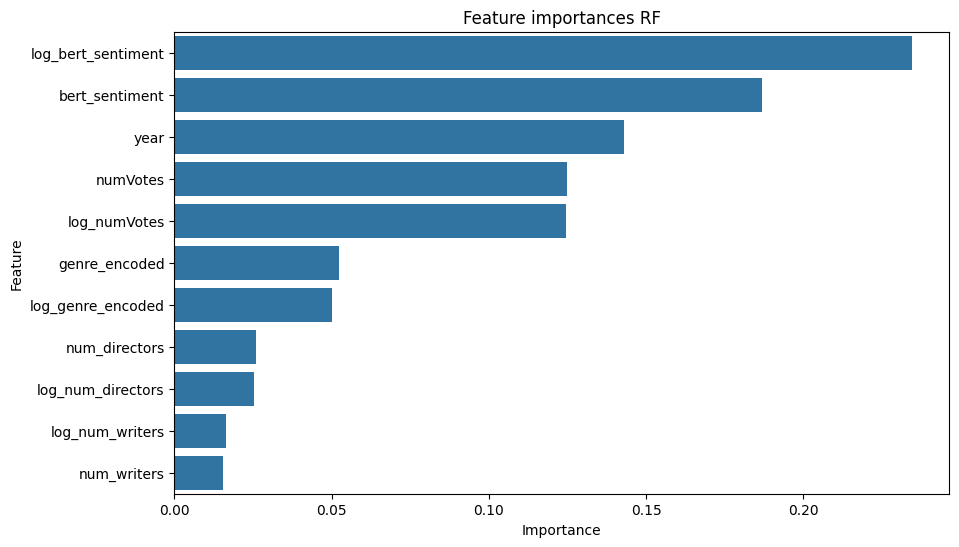

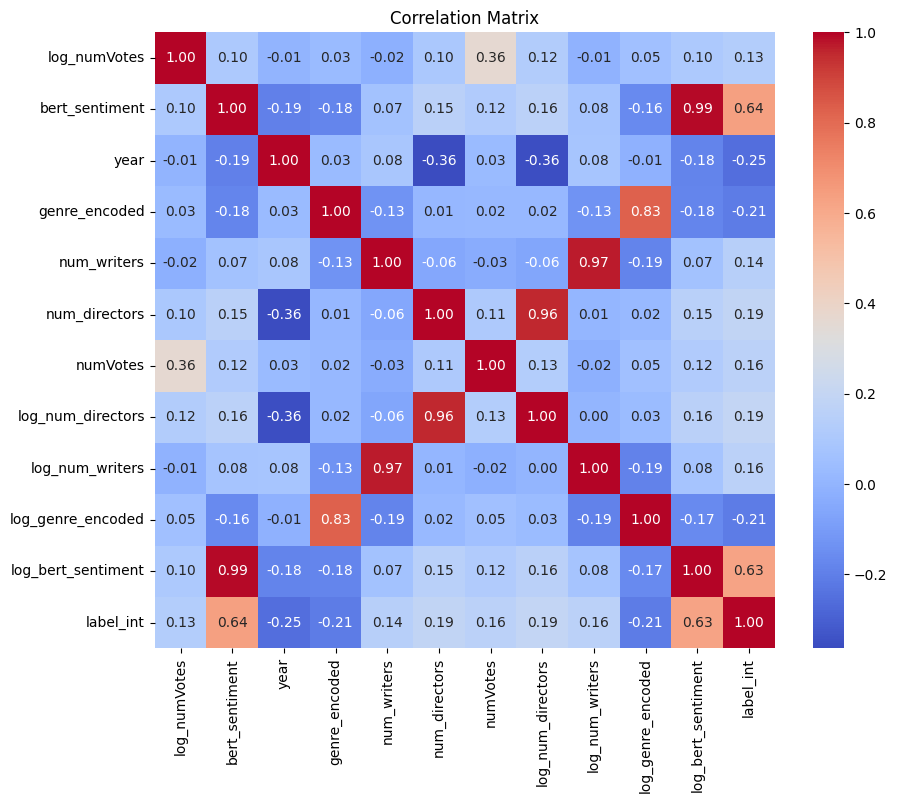

In [132]:
features = [
    'log_numVotes', 
    'bert_sentiment', 
    'year', 
    'genre_encoded', 
    'num_writers', 
    'num_directors', 
    'numVotes', 
    'log_num_directors', 
    'log_num_writers',
    'log_genre_encoded',
    'log_bert_sentiment',
    ]

# Define your target variable.
y = df['label_int']
X = df[features]

# Split the data for evaluation purposes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit RFC.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# feature importances from the model (traditional method)
importances = clf.feature_importances_
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances (from model):")
print(feature_importances)

# Plot feature importances.
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Feature importances RF")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# correlation matrix to inspect relationships.
corr_features = features + ['label_int']
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


Cross-validation results:
  Accuracy:  0.7592 ± 0.0522
  Precision: 0.7470 ± 0.0796
  Recall:    0.8272 ± 0.0898
  F1:        0.7761 ± 0.0182
  ROC AUC:   0.8568 ± 0.0515
Best parameters found:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Predictions saved to text files.
Test hidden: 778 positive predictions out of 1086
Validation hidden: 698 positive predictions out of 955
No ground truth labels for test set; accuracy cannot be computed.
No ground truth labels for validation set; accuracy cannot be computed.


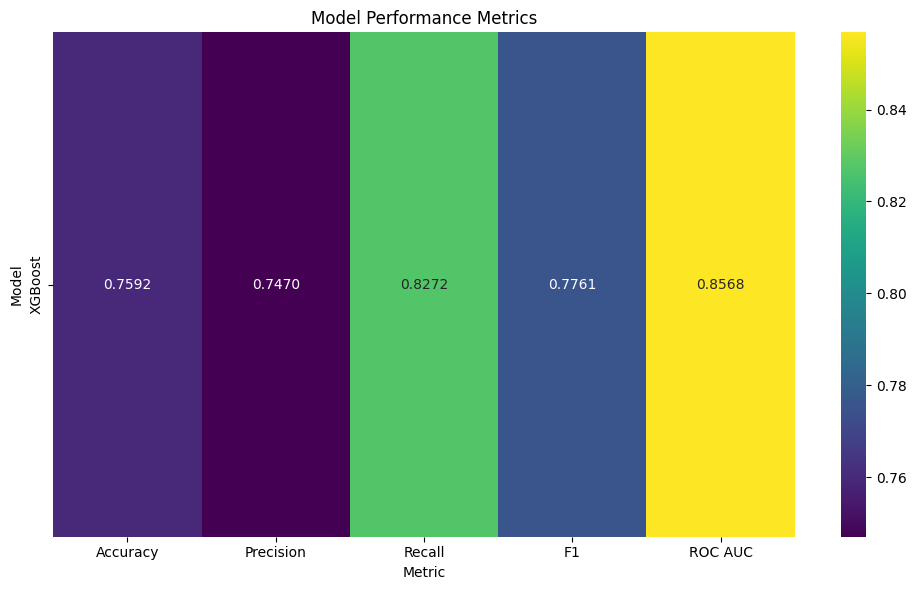

In [133]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score
import xgboost as xgb

# -------------------------------
# Define features for modeling
# -------------------------------
features = ['log_bert_sentiment', 'bert_sentiment', 'year', 'numVotes', 'log_numVotes', 'genre_encoded', 'log_genre_encoded']

# Training data
X = df[features]
y = df['label_int']

# Hidden test and validation features (ensure these DataFrames have a 'tconst' column and ground truth labels)
X_test_hidden = df_test_hidden[features]
X_validation_hidden = df_validation_hidden[features]

# -------------------------------
# Define parameter grid for XGBoost
# -------------------------------
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# -------------------------------
# Initialize the XGBoost model with GridSearchCV
# -------------------------------
model = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    xgb_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# -------------------------------
# Evaluate the model using cross-validation
# -------------------------------
cv_results = cross_validate(
    model, X, y, cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("Cross-validation results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"  F1:        {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
print(f"  ROC AUC:   {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")

# -------------------------------
# Fit the model on the entire training set
# -------------------------------
model.fit(X, y)
print("Best parameters found:")
print(model.best_params_)

# make predictions on hidden test and val
test_hidden_preds = model.predict(X_test_hidden)
validation_hidden_preds = model.predict(X_validation_hidden)

# Convert numeric predictions to 'True'/'False' strings
test_hidden_preds_str = ['True' if pred == 1 else 'False' for pred in test_hidden_preds]
validation_hidden_preds_str = ['True' if pred == 1 else 'False' for pred in validation_hidden_preds]

eval_results = {
    'Accuracy': cv_results['test_accuracy'].mean(),
    'Precision': cv_results['test_precision'].mean(),
    'Recall': cv_results['test_recall'].mean(),
    'F1': cv_results['test_f1'].mean(),
    'ROC AUC': cv_results['test_roc_auc'].mean()
}
results_df = pd.DataFrame([eval_results], index=['XGBoost'])

plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, cmap='viridis', fmt='.4f')
plt.title('Model Performance Metrics')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


In [136]:
# save predictions in txt files
with open('test_hidden_XGBoost_again.txt', 'w') as f:
    f.write('\n'.join(test_hidden_preds_str))

with open('validation_hidden_XGBoost_again.txt', 'w') as f:
    f.write('\n'.join(validation_hidden_preds_str))

print("Predictions saved to text files.")


Predictions saved to text files.
